## sircat

makes a catalog of solar wind stream interaction regions (SIRs) for the Wind and STEREO spacecraft since 2007

Authors: [C. Möstl](https://www.iwf.oeaw.ac.at/en/user-site/christian-moestl/) (twitter @chrisoutofspace), A. J. Weiss, R. L. Bailey, IWF Graz, Austria; Lan Jian, NASA, USA.


**current status: work in progress** 

to do: merge the times of the Wind and STEREO catalogs: STEREO needs HSS end time (definition: vt < 450 km/s), calculate HSS max time, calculate parameters for STEREO HSS 

If you want to use parts of this code for generating results for peer-reviewed scientific publications, please contact me per email (christian.moestl@oeaw.ac.at) or via https://twitter.com/chrisoutofspace for co-authorships.


part of https://github.com/cmoestl/heliocats, last update April 2020

---

### Installation 
Install a specific conda environment to run this code, see readme at https://github.com/cmoestl/heliocats


### Updates

Adding a new SIR event: add times in section 2 (to be done) before the master file sircat/HELCATS_SIRCAT_v10_master.xlsx is produced. Then delete the file for the respective spacecraft under sircat/indices_sircat, and run this notebook or script.

---


### Data sources

**STEREO SIR list**: Lan Jian, https://stereo-ssc.nascom.nasa.gov/data/ins_data/impact/level3/
published in:

L. K. Jian, J. G. Luhmann, C. T. Russell, A. B. Galvin, Solar-Terrestrial Relations Observatory (STEREO) Observations of Stream Interaction Regions in 2007-2016: Relationship with Heliospheric Current Sheets, Solar Cycle Variations, and Dual Observations, Solar Phys., 294, 31, https://doi.org/10.1007/s11207-019-1416-8, 2019.

The STEREO SIR list currently includes events from 2007 January 1 to 2018 July 31.


**Earth SIR/HSS list**: Maxim Grandin et al., 2018, https://doi.org/10.1029/2018JA026396

---


**Review on SIRs** by Ian G. Richardson: https://link.springer.com/article/10.1007/s41116-017-0011-z



Convert this notebook to a script with "jupyter nbconvert --to script sircat.ipynb"



In [1]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
import seaborn as sns
import datetime
import astropy
import astropy.constants as const
from sunpy.time import parse_time
import time
import pickle
import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py

from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

#where the in situ data files are located is read 
#from config.py 
import config
importlib.reload(config)
from config import data_path
from config import data_path_ML


########### make directories first time if not there

resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

indexdir='sircat/indices_sircat' 
if os.path.isdir(indexdir) == False: os.mkdir(indexdir) 

catdir='sircat'
if os.path.isdir(catdir) == False: os.mkdir(catdir)

sirplotsdir='sircat/plots_sircat/' 
if os.path.isdir(sirplotsdir) == False: os.mkdir(sirplotsdir) 

#Convert this notebook to a script with jupyter nbconvert --to script icmecat.ipynb
os.system('jupyter nbconvert --to script sircat.ipynb')    


#data is updated via the icmecat.ipynb notebook
    

0

## (1) load data from HELCATS, or made with HelioSat and heliocats.data

In [2]:
load_data=1

if load_data > 0:
    
        
    #print('load Ulysses RTN') #made with heliocats.data.save_ulysses_data
    #fileuly='ulysses_1990_2009_rtn.p'
    #[uly,huly]=pickle.load(open(data_path+fileuly, "rb" ) )      
    
    print('load STEREO-B data SCEQ') #yearly magplasma files from stereo science center, conversion to SCEQ 
    filestb='stereob_2007_2014_sceq.p'
    [stb,hstb]=pickle.load(open(data_path+filestb, "rb" ) )      
 

    ########### CURRENT ACTIVE SPACECRAFT    

    
    # ADD BepiColombo  
    
    
    # ADD Solar Orbiter
    
       
    #print('load MAVEN data MSO') #removed magnetosphere by C. Simon Wedlund, 1 data point per orbit, MSO 
    #filemav='maven_2014_2018.p'
    #[mav,hmav]=pickle.load(open(filemav, 'rb' ) )
    #filemav='maven_2014_2018_removed.p'
    #[mav,hmav]=pickle.load(open(filemav, 'rb' ) )    
    #filemav='maven_2014_2018_removed_smoothed.p'
    #[mav,hmav]=pickle.load(open(data_path+filemav, 'rb' ) )
    
    #print('load MSL RAD')
    #MSL RAD
    #rad=hd.load_msl_rad()#, rad.time,rad.dose_sol

    
    #print('load PSP data SCEQ') #from heliosat, converted to SCEQ similar to STEREO-A/B
    #filepsp='psp_2018_2019_sceq.p'
    #[psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) ) 
    
    
    print('load and merge STEREO-A data SCEQ') #yearly magplasma files from stereo science center, conversion to SCEQ 
    filesta1='stereoa_2007_2019_sceq.p'
    [sta1,hsta1]=pickle.load(open(data_path+filesta1, "rb" ) )  
    sta1=sta1[np.where(sta1.time < parse_time('2019-Sep-01 00:00').datetime)[0]]

    #beacon data
    filesta2="stereoa_2019_2020_sceq_beacon.p"
    [sta2,hsta2]=pickle.load(open(data_path+filesta2, "rb" ) )  
    sta2=sta2[np.where(sta2.time >= parse_time('2019-Sep-01 00:00').datetime)[0]]

    #make array
    sta=np.zeros(np.size(sta1.time)+np.size(sta2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    sta = sta.view(np.recarray)  
    sta.time=np.hstack((sta1.time,sta2.time))
    sta.bx=np.hstack((sta1.bx,sta2.bx))
    sta.by=np.hstack((sta1.by,sta2.by))
    sta.bz=np.hstack((sta1.bz,sta2.bz))
    sta.bt=np.hstack((sta1.bt,sta2.bt))
    sta.vt=np.hstack((sta1.vt,sta2.vt))
    sta.np=np.hstack((sta1.np,sta2.np))
    sta.tp=np.hstack((sta1.tp,sta2.tp))
    sta.x=np.hstack((sta1.x,sta2.x))
    sta.y=np.hstack((sta1.y,sta2.y))
    sta.z=np.hstack((sta1.z,sta2.z))
    sta.r=np.hstack((sta1.r,sta2.r))
    sta.lon=np.hstack((sta1.lon,sta2.lon))
    sta.lat=np.hstack((sta1.lat,sta2.lat))
    print('STA Merging done')

    
    
    print('load and merge Wind data HEEQ') 
    #from HELCATS HEEQ until 2018 1 1 + new self-processed data with heliosat and hd.save_wind_data
    filewin="wind_2007_2018_heeq_helcats.p" 
    [win1,hwin1]=pickle.load(open(data_path+filewin, "rb" ) )  
    
    #or use: filewin2="wind_2018_now_heeq.p" 
    filewin2="wind_2018_2019_heeq.p" 
    [win2,hwin2]=pickle.load(open(data_path+filewin2, "rb" ) )  

    #merge Wind old and new data 
    #cut off HELCATS data at end of 2017, win2 begins exactly after this
    win1=win1[np.where(win1.time < parse_time('2018-Jan-01 00:00').datetime)[0]]
    #make array
    win=np.zeros(np.size(win1.time)+np.size(win2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    win = win.view(np.recarray)  
    win.time=np.hstack((win1.time,win2.time))
    win.bx=np.hstack((win1.bx,win2.bx))
    win.by=np.hstack((win1.by,win2.by))
    win.bz=np.hstack((win1.bz,win2.bz))
    win.bt=np.hstack((win1.bt,win2.bt))
    win.vt=np.hstack((win1.vt,win2.vt))
    win.np=np.hstack((win1.np,win2.np))
    win.tp=np.hstack((win1.tp,win2.tp))
    win.x=np.hstack((win1.x,win2.x))
    win.y=np.hstack((win1.y,win2.y))
    win.z=np.hstack((win1.z,win2.z))
    win.r=np.hstack((win1.r,win2.r))
    win.lon=np.hstack((win1.lon,win2.lon))
    win.lat=np.hstack((win1.lat,win2.lat))

    print('Wind merging done')
    
    

#HIGEOCAT
higeocat=hc.load_higeocat()
higeocat_time=parse_time(higeocat['Date']).datetime    
    

     
         
print()
    
print()       
print('time ranges of the in situ data: ')    
print()
print('active spacecraft:')
print('Wind                 ',str(win.time[0])[0:10],str(win.time[-1])[0:10])
print('STEREO-A             ',str(sta.time[0])[0:10],str(sta.time[-1])[0:10])
#print('Parker Solar Probe   ',str(psp.time[0])[0:10],str(psp.time[-1])[0:10])
#print('MAVEN                ',str(mav.time[0])[0:10],str(mav.time[-1])[0:10])
#print('MSL/RAD              ',str(rad.time[0])[0:10],str(rad.time[-1])[0:10])
print()
print('missions finished:')
#print('VEX                  ',str(vex.time[0])[0:10],str(vex.time[-1])[0:10])
#print('MESSENGER            ',str(mes.time[0])[0:10],str(mes.time[-1])[0:10])
print('STEREO-B             ',str(stb.time[0])[0:10],str(stb.time[-1])[0:10])
#print('Ulysses              ',str(uly.time[0])[0:10],str(uly.time[-1])[0:10])
print()
# print('catalogs:')
# print()
# print('HELCATS HIGeoCAT     ',str(higeocat_time[0])[0:10],str(higeocat_time[-1])[0:10])



print('done')

load STEREO-B data SCEQ
load and merge STEREO-A data SCEQ
STA Merging done
load and merge Wind data HEEQ
Wind merging done


time ranges of the in situ data: 

active spacecraft:
Wind                  2007-01-01 2019-12-31
STEREO-A              2007-01-01 2020-04-15

missions finished:
STEREO-B              2007-01-01 2014-09-27

done


## (2) make SIRCAT masterfile from STEREO and Wind catalogs

In [12]:
###################### read raw STEREO SIR catalog

file='sircat/sources/STEREO_Level3_SIR_data.xlsx'
print('load Jian STEREO catalog from excel file:', file)
sraw=pd.read_excel(file)


#2 times: SIR/HSS start, HSS end (where speed again < 450km/s)


print('Events in STEREO SIR cat:', sraw.shape[0])

sc=sraw.loc[:,'spacecraft']

year_start=sraw.loc[:,'year_start']
stime=sraw.loc[:,'start_time']

year_end=sraw.loc[:,'year_end']
etime=sraw.loc[:,'end_time']

year_pt=sraw.loc[:,'year_pt']
ptime=sraw.loc[:,'pt_time']

print('convert times to datetime objects')

#make list for all basic times, ids etc. for master file
rows_list = []


for i in np.arange(0,sraw.shape[0]):
    
    s=stime[i]    
    y=year_start[i]
    doy=int(s[0:3])
    hour=int(s[-5:-3])
    minute=int(s[-2:])
    #print(y,doy,hour, min)
    sir_start_time=datetime.datetime(y,1,1)+timedelta(days=doy-1)+timedelta(hours=hour)+timedelta(minutes=minute)

    e=etime[i]    
    y=year_end[i]
    doy=int(e[0:3])
    hour=int(e[-5:-3])
    minute=int(e[-2:])
    #print(y,doy,hour, min)
    sir_end_time=datetime.datetime(y,1,1)+timedelta(days=doy-1)+timedelta(hours=hour)+timedelta(minutes=minute)
    
    #make id for event    
    id_time=parse_time(sir_start_time).isot
    if sc[i]=='A': sc_idstring='SIR_STEREO_A_JIAN_'
    if sc[i]=='B': sc_idstring='SIR_STEREO_B_JIAN_'

    if sc[i]=='A': sc_string='STEREO-A'
    if sc[i]=='B': sc_string='STEREO-B'
        
    sircat_id=sc_idstring+id_time[0:4]+id_time[5:7]+id_time[8:10]+'_01'
    
    #put all data for this event in a list
    list1 = [sircat_id,sc_string,parse_time(sir_start_time).isot,parse_time(sir_end_time).isot,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan]
    
    #print(list1)    
    #append to full list
    rows_list.append(list1)
    



########################## read raw Wind catalog

#Grandin et al. 2018 - OMNI
#removed 2 SIRs due to data gap of Wind in oct 2014
wraw=np.loadtxt('sircat/sources/grandin_2018_list_modified.txt',skiprows=9)

print('Events in Wind SIR/HSS cat:', wraw.shape[0])

#2 times: SIR/HSS start, HSS end (where speed again < 450km/s)

#begin with 2007
begin2007=np.where(wraw[:,1]>=2007)[0][0]


for i in np.arange(begin2007,len(wraw),1):

    
    #SIR HSS start time y,m,d,h,m - minus 1 hour for Wind at L1, not magnetopause
    wstart=datetime.datetime(wraw[i,1].astype(int),wraw[i,2].astype(int), \
                             wraw[i,3].astype(int),wraw[i,4].astype(int), \
                             0)-datetime.timedelta(hours=1) 
    #SIR HSS start time y,m,d,h,m - minus 1 hour for Wind at L1, not magnetopause
    wend=datetime.datetime(wraw[i,11].astype(int),wraw[i,12].astype(int), \
                             wraw[i,13].astype(int),wraw[i,14].astype(int), \
                             0)-datetime.timedelta(hours=1)



    sc_idstring='SIR_WIND_GRANDIN_'
    id_time=parse_time(wstart).isot
    sircat_id=sc_idstring+id_time[0:4]+id_time[5:7]+id_time[8:10]+'_01'
    sc_string='Wind'
    
    list2 = [sircat_id,sc_string,parse_time(wstart).isot,np.nan,parse_time(wend).isot,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan]
    
    #print(list2)

    rows_list.append(list2)


    

    
###################################  add new events
#for measuring new events use this function from heliocats.plot 
#plt.close('all')
#works in jupyter notebooks

#works in scripts
#matplotlib.use('qt5agg')  
#plt.ion()

#STEREO-A
#hp.plot_insitu_measure(sta, '2018-Jan-01 12:00','2018-Feb-01 12:00', 'STEREO-A', 'results/')

#Wind
#hp.plot_insitu_measure(win, '2019-Jan-29','2019-Feb-28', 'Wind', 'results/')

    
    
    
################ make pandas data frame for master file
        
parameters =['sircat_id','sc_insitu','sir_start_time','sir_end_time',\
             'hss_end_time','hss_vtmax_time','sc_heliodistance',\
             'sc_long_heeq', 'sc_lat_heeq', 
             'hss_vtmax','hss_vtmean','hss_vtstd','hss_btmax','hss_btmean',\
             'hss_btstd','hss_bzmin', 'hss_bzmean','hss_bzstd','hss_duration',\
             'sir_vtmax','sir_vtmean', 'sir_vtstd','sir_btmax','sir_btmean',\
             'sir_btstd','sir_bzmin', 'sir_bzmean','sir_bzstd','sir_duration']


master=pd.DataFrame(rows_list,columns=parameters)


#sort by spacecraft indicator
master=master.sort_values(['sc_insitu','sir_start_time'])
master = master.reset_index(drop=True)


master
   



#save master file as Excel
file='sircat/HELCATS_SIRCAT_v10_master.xlsx'
master.to_excel(file,sheet_name='SIRCATv1.0')
print()
print('SIRCAT master saved as '+file)
print('done')

load Jian STEREO catalog from excel file: sircat/sources/STEREO_Level3_SIR_data.xlsx
Events in STEREO SIR cat: 655
convert times to datetime objects
Events in Wind SIR/HSS cat: 586

SIRCAT master saved as sircat/HELCATS_SIRCAT_v10_master.xlsx
done


## (3) make SIRCAT 

load HELCATS SIRCAT from file: sircat/HELCATS_SIRCAT_v10_master.xlsx
done
Get parameters for  STEREO-A
position
hss
sir
Get parameters for  STEREO-B
position
hss
sir
Get parameters for  Wind
position
hss
sir
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070225_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070304_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070311_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070323_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070329_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070408_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070421_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070426_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070507_01.png


KeyboardInterrupt: 

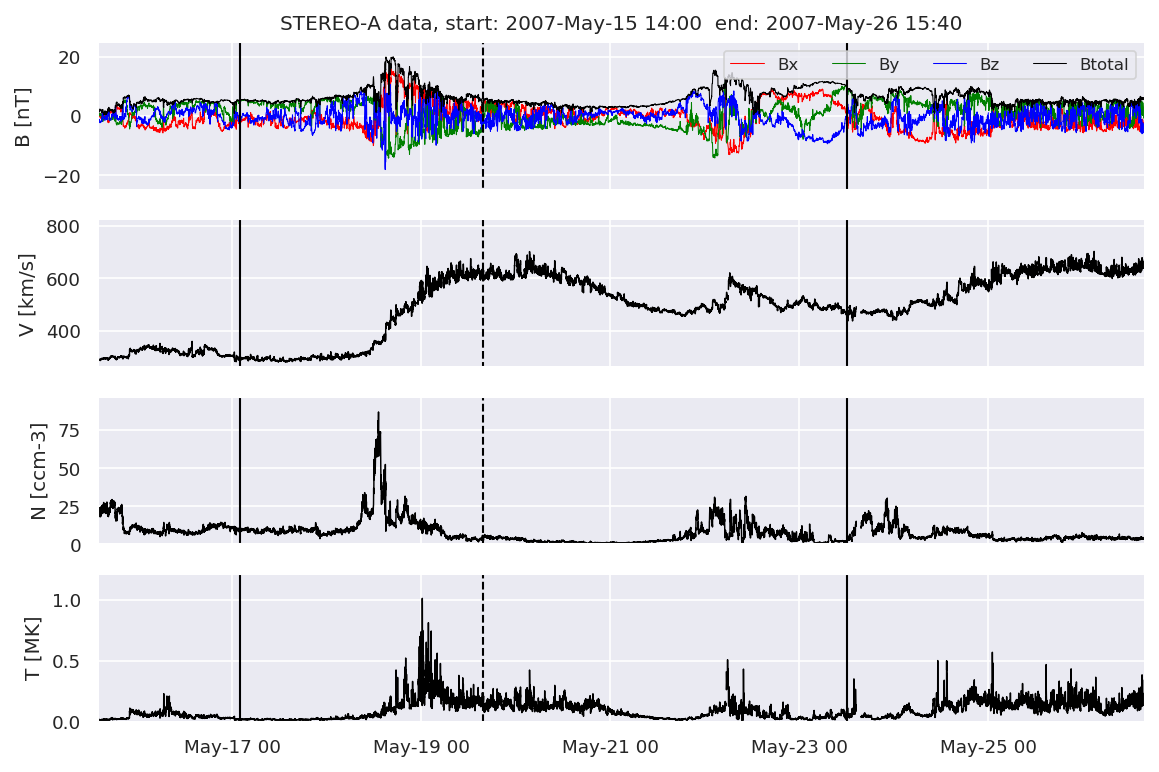

In [121]:

from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

#load master file
scat=hc.load_helcats_sircat_master_from_excel('sircat/HELCATS_SIRCAT_v10_master.xlsx')
scat



####### 3a get indices for all spacecraft
stai=np.where(scat.sc_insitu == 'STEREO-A')[:][0]    
stbi=np.where(scat.sc_insitu == 'STEREO-B')[:][0]    
wini=np.where(scat.sc_insitu == 'Wind')[:][0] 

print('done')

####### 3b get parameters for all spacecraft one after another

# remove indices if the  events in the master file have changed
#os.system('rm sircat/indices_sircat/SIRCAT_indices_Wind.p')
#os.system('rm sircat/indices_sircat/SIRCAT_indices_STEREO-A.p')
#os.system('rm sircat/indices_sircat/SIRCAT_indices_STEREO-B.p')


scat=hc.get_sircat_parameters(sta,stai,scat,'STEREO-A')
scat=hc.get_sircat_parameters(stb,stbi,scat,'STEREO-B')
scat=hc.get_sircat_parameters(win,wini,scat,'Wind')


# ###### 3c make all plots if wanted
#matplotlib.use('Agg')
#hp.plot_sircat_events(sta,stai,scat,'STEREO-A',sirplotsdir)
#hp.plot_sircat_events(stb,stbi,scat,'STEREO-B',sirplotsdir)
#hp.plot_sircat_events(win,wini,scat,'Wind',sirplotsdir)



print('done')


### (4) save SIRCAT 

### 4a save header

In [116]:
#save header and parameters as text file and prepare for html website
header='SIR CATALOGUE v1.0 \n\n\
This is the HELCATS stream interaction region (SRI) catalog, based on in situ magnetic field and bulk plasma observations in the heliosphere. \n\n\
This is version 1.0, released 2020-**-**. DOI: 10.6084/m9.**** \n\n\
The catalog is available as  python pandas dataframe (pickle), python numpy structured array (pickle), json, csv, xlsx, txt, hdf5, at \n\
https://helioforecast.space/sircat \n\
https://www.helcats-fp7.eu/catalogues/wp4_sircat.html \n\n\
Number of events in SIRCAT: '+str(len(scat))+' \n\
ICME observatories: Wind, STEREO-A, STEREO-B.   \n\
Time range: January 2007 - July 2018. \n\n\
Authors: Christian Moestl, Andreas Weiss, R. L. Bailey, Space Research Institute, Austrian Academy of Sciences, Graz, Austria. Lan Jian, NASA, USA, Maxim Grandin, University of Helsinki, Finland. \n\n\
Rules: If results are produced with this catalog for peer-reviewed scientific publications, please contact christian.moestl@oeaw.ac.at for possible co-authorship. \n\n\
This catalog has been made by getting the start and end times of each SIR from the individual catalogs below, and then calculating all parameters again consistently from \
the data by us. \n\
The in situ data that were used for the catalog, with a size of 8 GB in total, including extra data files with magnetic field components \
in RTN coordinates that are not used for producing the catalog and many other in situ data files, can be downloaded in python pickle format as recarrays from \
https://doi.org/10.6084/m9.figshare.11973693 \n\
The python code for producing this catalog is available as part of https://github.com/cmoestl/heliocats \n\n\
Each icmecat_id has a tag in it that indicates from which catalog the ICME times were taken: \n\n\
STEREO-A:   Jian et al. (2019), tag: JIAN. \n\
STEREO-B:   Jian et al. (2019), tag: JIAN. \n\
Wind:       Grandin et al. (2018), tag: GRANDIN \n\n\
References \n\
Grandin, M. et al. (2018), https://doi.org/10.1029/2018JA026396, 2019. \n\
Jian, L. et al. (2019), https://doi.org/10.1007/s11207-019-1416-8, 2019. \n\n\
Comments: \n\
- Spacecraft positions are given in Heliocentric Earth Equatorial Coordinates (HEEQ) coordinates. \n\
- The coordinate system for all magnetic field components is SCEQ, except for Wind (HEEQ, which is the equivalent for SCEQ for Earth). \n\
        Definition of SpaceCraft Equatorial Coordinates (SCEQ): \n\
        Z is the solar rotation axis. \n\
        Y is the cross product of Z and R, with R being the vector that points from the Sun to the spacecraft.\n\
        X completes the right handed triad (and points away from the Sun). \n\
This system is thus like HEEQ but centered on the respective in situ spacecraft, so the SCEQ X and Y \n\
base vectors are rotated by the HEEQ longitude of the in situ spacecraft from HEEQ X and Y.\n\
The Y vector is similar to the T vector in an RTN system for each spacecraft, but the X and Z vectors \n\
are rotated around Y compared to an RTN system. The differences between RTN and SCEQ for spacecraft within \n\
a few degrees of the solar equatorial plane are very small (within a few 0.1 nT usually).\n\
We choose SCEQ because it has the advantage that a comparison between multipoint CME events \n\
and for comparison to simulations there is always a similar reference plane (the solar equatorial plane). \n\n '     


                       
parameters='Parameters: \n\ to be defined'


print(header)
print(parameters)


#make header file
file='sircat/HELCATS_SIRCAT_v10_header.txt'
with open(file, "w") as text_file:
    text_file.write(header)
    text_file.write(parameters)
print()    
print('header saved as '+file)
print()    

#Convert to html regarding line breaks, paragraph beginning and spaces
header_spaces=header.replace(" ", "&nbsp;")
header_html= "<p>" +header_spaces.replace('\n', '<br>')+ "</p>" 
parameters_spaces=parameters.replace(" ", "&nbsp;")
parameters_html= "<p>" +parameters.replace('\n', '<br>')+ "</p>"
print('header converted to HTML')
print()    
print()    

SIR CATALOGUE v1.0 

This is the HELCATS stream interaction region (SRI) catalog, based on in situ magnetic field and bulk plasma observations in the heliosphere. 

This is version 1.0, released 2020-**-**. DOI: 10.6084/m9.**** 

The catalog is available as  python pandas dataframe (pickle), python numpy structured array (pickle), json, csv, xlsx, txt, hdf5, at 
https://helioforecast.space/sircat 
https://www.helcats-fp7.eu/catalogues/wp4_sircat.html 

Number of events in SIRCAT: 931 
ICME observatories: Wind, STEREO-A, STEREO-B.   
Time range: January 2007 - July 2018. 

Authors: Christian Moestl, Andreas Weiss, R. L. Bailey, Space Research Institute, Austrian Academy of Sciences, Graz, Austria. Lan Jian, NASA, USA, Maxim Grandin, University of Helsinki, Finland. 

Rules: If results are produced with this catalog for peer-reviewed scientific publications, please contact christian.moestl@oeaw.ac.at for possible co-authorship. 

This catalog has been made by getting the start and end ti

### 4b save into different formats

In [128]:
########## python formats

# save ICMECAT as pandas dataframe with times as datetime objects as pickle
file='sircat/HELCATS_SIRCAT_v10_pandas.p'
pickle.dump([scat,header,parameters], open(file, 'wb'))
print('SIRCAT saved as '+file)



#load sircat as pandas dataframe
file='sircat/HELCATS_SIRCAT_v10_pandas.p'
[scat_pandas,h,p]=pickle.load( open(file, 'rb'))   
scat.keys()
scat



# # save SIRCAT as numpy array with times as matplotlib datetime as pickle
# scat_num=copy.deepcopy(scat) 
# scat_num.icme_start_time=parse_time(scat_num.icme_start_time).plot_date
# scat_num.mo_start_time=parse_time(scat_num.mo_start_time).plot_date
# scat_num.mo_end_time=parse_time(scat_num.mo_end_time).plot_date
# #convert to recarray
# scat_num_rec=scat_num.to_records()
# #create structured array
# dtype1=[('index','i8'),('icmecat_id', '<U30'),('sc_insitu', '<U20')] +[(i, '<f8') for i in ic.keys()[2:len(ic.keys())]]
# scat_num_struct=np.array(scat_num_rec,dtype=dtype1)



# file='icmecat/HELCATS_ICMECAT_v20_numpy.p'
# pickle.dump([scat_num,scat_num_struct,header,parameters], open(file, 'wb'))
# print('ICMECAT saved as '+file)



################ save to different formats

#copy pandas dataframe first to change time format consistent with HELCATS
scat_copy=copy.deepcopy(scat)  
scat_copy.sir_start_time=parse_time(scat.sir_start_time).isot
scat_copy.hss_end_time=parse_time(scat.hss_end_time).isot
scat_copy.hss_vtmax_time=parse_time(scat.hss_vtmax_time).isot

scat_copy.at[stai,'sir_end_time']=parse_time(scat.sir_end_time[stai]).isot
scat_copy.at[stbi,'sir_end_time']=parse_time(scat.sir_end_time[stbi]).isot




#change time format
for i in np.arange(len(scat)):

    dum=scat_copy.sir_start_time[i] 
    scat_copy.at[i,'sir_start_time']=dum[0:16]+'Z'
    
    dum=scat_copy.hss_end_time[i] 
    scat_copy.at[i,'hss_end_time']=dum[0:16]+'Z'

    dum=scat_copy.hss_vtmax_time[i] 
    scat_copy.at[i,'hss_vtmax_time']=dum[0:16]+'Z'



     

for i in stbi:
    dum=scat_copy.sir_end_time[i] 
    scat_copy.at[i,'sir_end_time']=dum[0:16]+'Z'

for i in stai:
    dum=scat_copy.sir_end_time[i] 
    scat_copy.at[i,'sir_end_time']=dum[0:16]+'Z'
    




#save as Excel
file='sircat/HELCATS_SIRCAT_v10.xlsx'
scat_copy.to_excel(file,sheet_name='SIRCATv1.0')
print('SIRCAT saved as '+file)

#save as json
file='sircat/HELCATS_SIRCAT_v10.json'
scat_copy.to_json(file)
print('SIRCAT saved as '+file)

#save as csv
file='sircat/HELCATS_SIRCAT_v10.csv'
scat_copy.to_csv(file)
print('SIRCAT saved as '+file)

#save as txt
file='sircat/HELCATS_SIRCAT_v10.txt'
np.savetxt(file, scat_copy.values.astype(str), fmt='%s' )
print('SIRCAT saved as '+file)






#########################


# #########save into hdf5 format , use S for strings http://docs.h5py.org/en/stable/strings.html#what-about-numpy-s-u-type
# dtype2=[('index','i8'),('icmecat_id', 'S30'),('sc_insitu', 'S20')] +[(i, '<f8') for i in ic.keys()[2:len(ic.keys())]]
# ich5=np.array(scat_num_rec,dtype=dtype2)
# file='icmecat/HELCATS_ICMECAT_v20.h5'
# f=h5py.File(file,mode='w')
# f["icmecat"]= ich5
# #add attributes
# #************************
# #***********************

# print('ICMECAT saved as '+file)
# f.close()

# #reading h5py files http://docs.h5py.org/en/latest/quick.html
# #fr = h5py.File('icmecat/HELCATS_ICMECAT_v20.h5', 'r')
# #list(fr.keys())
# #ich5=fr['icmecat']
# #ich5['mo_bstd']
# #ich5.dtype
# #fr.close()
# ##################


# #save as .npy without pickle
# file='icmecat/HELCATS_ICMECAT_v20_numpy.npy'
# np.save(file,ich5, allow_pickle=False)
# print('ICMECAT saved as '+file)

# #for loading do:
# #icnpy=np.load(file)
# #decode strings:
# #icnpy['icmecat_id'][0].decode()


#copy pandas dataframe first to change time format consistent with HELCATS
scat_copy2=copy.deepcopy(scat)  
scat_copy2.sir_start_time=parse_time(scat.sir_start_time).iso
scat_copy2.hss_end_time=parse_time(scat.hss_end_time).iso
scat_copy2.hss_vtmax_time=parse_time(scat.hss_vtmax_time).iso


scat_copy2.at[stai,'sir_end_time']=parse_time(scat.sir_end_time[stai]).iso
scat_copy2.at[stbi,'sir_end_time']=parse_time(scat.sir_end_time[stbi]).iso



#change time format
for i in np.arange(len(scat)):

    dum=scat_copy2.sir_start_time[i] 
    scat_copy2.at[i,'sir_start_time']=dum[0:16]
    
    dum=scat_copy2.hss_end_time[i] 
    scat_copy2.at[i,'hss_end_time']=dum[0:16]
            
    dum=scat_copy2.hss_vtmax_time[i] 
    scat_copy2.at[i,'hss_vtmax_time']=dum[0:16]


     

for i in stbi:
    dum=scat_copy2.sir_end_time[i] 
    scat_copy2.at[i,'sir_end_time']=dum[0:16]

for i in stai:
    dum=scat_copy2.sir_end_time[i] 
    scat_copy2.at[i,'sir_end_time']=dum[0:16]
    




#save as json for webpage with different time format
file='sircat/HELCATS_SIRCAT_v10_isot.json'
scat_copy2.to_json(file)
print('SIRCAT saved as '+file)



#save as html no header
file='sircat/HELCATS_SIRCAT_v10_simple.html'
scat_copy.to_html(file)
print('SIRCAT saved as '+file)


############ save as html file with header
#save as html
file='sircat/HELCATS_SIRCAT_v10.html'
#ic.to_html(file,justify='center')

#ichtml='{% extends "_base.html" %} \n \n {% block content %} \n \n \n '
ichtml = header_html
ichtml += parameters_html
ichtml += scat_copy.to_html()
#ichtml +='\n \n {% endblock %}'


with open(file,'w') as f:
    f.write(ichtml)
    f.close()
    
print('SIRCAT saved as '+file)    


SIRCAT saved as sircat/HELCATS_SIRCAT_v10_pandas.p
SIRCAT saved as sircat/HELCATS_SIRCAT_v10.xlsx
SIRCAT saved as sircat/HELCATS_SIRCAT_v10.json
SIRCAT saved as sircat/HELCATS_SIRCAT_v10.csv
SIRCAT saved as sircat/HELCATS_SIRCAT_v10.txt
SIRCAT saved as sircat/HELCATS_SIRCAT_v10_isot.json
SIRCAT saved as sircat/HELCATS_SIRCAT_v10_simple.html
SIRCAT saved as sircat/HELCATS_SIRCAT_v10.html


## 4c load ICMECAT pickle files

In [118]:

#load sircat as pandas dataframe
file='sircat/HELCATS_SIRCAT_v10_pandas.p'
[scat_pandas,h,p]=pickle.load( open(file, 'rb'))   
scat.keys()
scat

#load icmecat as numpy array
# file='icmecat/HELCATS_ICMECAT_v20_numpy.p'
# [ic_nprec,ic_np,h,p]=pickle.load( open(file, 'rb'))   


,sircat_id,sc_insitu,sir_start_time,sir_end_time,hss_end_time,hss_vtmax_time,sc_heliodistance,sc_long_heeq,sc_lat_heeq,hss_vtmax,...,sir_vtmax,sir_vtmean,sir_vtstd,sir_btmax,sir_btmean,sir_btstd,sir_bzmin,sir_bzmean,sir_bzstd,sir_duration
0,SIR_STEREO_A_JIAN_20070225_01,STEREO-A,2007-02-25 17:40:00,2007-03-01 01:10:00,2007-03-02 11:39:00,NaN,0.9681,0.97,-7.28,692.9,...,692.9,476.5,116.7,13.4,7.0,2.3,-11.8,0.2,3.7,79.50
1,SIR_STEREO_A_JIAN_20070304_01,STEREO-A,2007-03-04 15:50:00,2007-03-07 20:00:00,2007-03-08 10:48:00,NaN,0.9675,1.18,-7.35,693.2,...,693.2,475.0,82.7,11.0,6.5,1.9,-6.9,1.1,3.0,76.17
2,SIR_STEREO_A_JIAN_20070311_01,STEREO-A,2007-03-11 03:47:00,2007-03-14 06:30:00,2007-03-18 05:15:00,NaN,0.9668,1.40,-7.30,737.2,...,727.8,522.2,121.7,13.1,7.2,1.6,-8.5,-0.3,3.3,74.72
3,SIR_STEREO_A_JIAN_20070323_01,STEREO-A,2007-03-23 03:10:00,2007-03-28 12:00:00,2007-03-28 21:54:00,NaN,0.9657,1.89,-6.95,612.0,...,612.0,428.6,70.2,12.2,6.4,1.9,-10.6,0.2,3.8,128.83
4,SIR_STEREO_A_JIAN_20070329_01,STEREO-A,2007-03-29 13:30:00,2007-04-03 08:00:00,2007-04-05 02:13:00,NaN,0.9650,2.20,-6.63,686.0,...,686.0,454.1,101.1,12.5,5.4,1.9,-11.9,0.3,2.7,114.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,SIR_WIND_GRANDIN_20171115_01,Wind,2017-11-15 03:00:00,NaN,2017-11-17 01:00:00,NaN,0.9806,0.19,2.81,533.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.00
927,SIR_WIND_GRANDIN_20171120_01,Wind,2017-11-20 14:00:00,NaN,2017-11-22 20:00:00,NaN,0.9796,0.15,2.16,648.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.00
928,SIR_WIND_GRANDIN_20171204_01,Wind,2017-12-04 11:00:00,NaN,2017-12-08 08:00:00,NaN,0.9773,0.03,0.42,637.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.00
929,SIR_WIND_GRANDIN_20171211_01,Wind,2017-12-11 02:00:00,NaN,2017-12-13 05:00:00,NaN,0.9764,-0.03,-0.42,518.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.00


In [8]:
ic_pandas
ic_pandas.keys()

NameError: name 'ic_pandas' is not defined